### Code: Target Function

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss


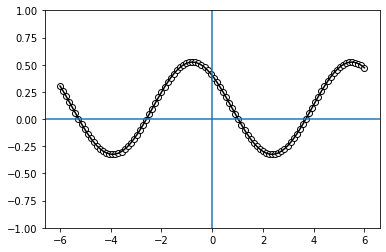

In [3]:
degree = 1  # degree of the target function
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff_0 = 0.1  # coefficient of zero frequency
data_points = 100  # number of datas
scale_target = 1.  # scale_target of the data

def target_function(x):
    res = 0.0 + 0.0j
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128((idx+1) * 1j * scale_target * x)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res + coeff_0)

x = np.linspace(-6, 6, data_points, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, color='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()


My first code block went smooth! The import and variable declaration is fine and all, yet there might be a small detail asking for a sharp attention. It's the fifth variable 'scale_target' declared to $1$. If this is anything but $1$ then the loss is huge and the trainable model all of the sudden becomes untrainable. This is what authors precisely meant is the account between the expressivity and the data encoding strategy. 

Better yet, define a 'scale_train' and set it to $1$. Now as long as the difference between 'scale_target' and 'scale_train' remains $0$ the model is trainable otherwise if not.

Next, I'll make a trainable model to train it! I hope to successfully replicate authors argument in following codes. 

### Trainable model randomly instantiated

In [4]:
scale_train_model = 1
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def quantum_model(weights, x):

    for (idx, theta) in enumerate(weights):

        ''' This is trainable circuit block. theta_tensor is the tensor containing the weights. The value of weights adjusts to approach the target function as close as possible. The updates happen batchwise. 
        
        The Rot method in qml is the general rotation operator which takes in three parameters theta, phi and a phase. '''
        qml.Rot(theta[0], theta[1], theta[2], wires=0)

        ''' This is encoding gate. It's a roation gate, if x = pi then this is a pauli X-gate '''
        if (idx == len(weights) -1):
            continue
        
        qml.RX(scale_train_model*x, wires=0)

    return qml.expval(qml.PauliZ(wires=0))


The 'weights' is a tensor. In this single-qubit case, it a $1\times3$ row matrix. In a n-qubit model it's $n\times3$ matrix. The three sticks around because 'Rot' method in the class 'qml' takes in exact three parameters. Moreover, the quantum model returns an expectation value for the Pauli Z-gate. Since Hadamard gate is never applied throught the entire model the Pauli Z-gate has no effect like that of an Identity operator/matrix. Well almost! Except for an additional phase of $\pi$ when operated on the state/qubit $|1>. 

$$\sigma_z|1> = e^{i\pi}|1>$$ 

Yet, this difference won't impact the measurement since the phase term is cancelled out by its conjugate during the measurement operation. So, for all the intend of measurement Pauli Z-gate has no effect! As simple as:

$$
<1|\sigma_z^{\dagger}\sigma_z|1> = <1|e^{-i\pi}e^{i\pi}|1>
$$
$$
\therefore <1|\sigma_z^{\dagger}\sigma_z|1> = <1|1> 
$$

I must mention there're nice places to play with qubits [8] [9]. The websites provide a visual and dataful experience. 

In the next code snippet, I have built a random trainable model. After it's visualized it's time to begin the long awaited training!

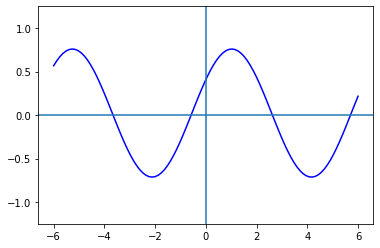

In [5]:
# number of times the encoding gets repeated (here equal to the number of layers)
r = 1

# some random initial weights
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True)

x = np.linspace(-6, 6, data_points, requires_grad=False)
random_quantum_model_y = [quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, color='blue')
plt.ylim(-1.25, 1.25)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()


In [6]:
print(qml.draw(quantum_model)(weights, x[-1]))

 0: ──Rot(2.35, 5.97, 4.6)──RX(6)──Rot(3.76, 0.98, 0.98)──┤ ⟨Z⟩ 



### Optimization/Learning for the parameteric circuit

In [7]:
def cost(weights, x, y):
    predictions = [quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

cost_ = [cost(weights, x, target_y)]

def optimizer_func(weights):
    # max_steps = 150
    # opt = qml.AdamOptimizer(stepsize=0.25)
    # batch_size = 30

    max_steps = 120
    opt = qml.AdamOptimizer(stepsize=0.4)
    batch_size = 40


    for step in range(max_steps):

        batch_index = np.random.randint(0, len(x), (batch_size,))
        x_batch = x[batch_index]
        y_batch = target_y[batch_index]

        # Update the weights by one optimizer step
        weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

        # Save, and possibly print, the current cost
        c = cost(weights, x, target_y)
        cost_.append(c)
        
        if (step + 1) % 15 == 0:
            print("Cost at step {0:3}: {1}".format(step + 1, c))
    
    return (weights, cost_)

(weights_scale_1_1, cost_1_1 )= optimizer_func(weights)

Cost at step  15: 0.0722666231955169
Cost at step  30: 0.011944659602031369
Cost at step  45: 0.0008478812775901242
Cost at step  60: 0.0009749460834098915
Cost at step  75: 0.00012814578078917135
Cost at step  90: 3.678618857270698e-05
Cost at step 105: 1.664770666812511e-05
Cost at step 120: 5.637304497008881e-07


### Result

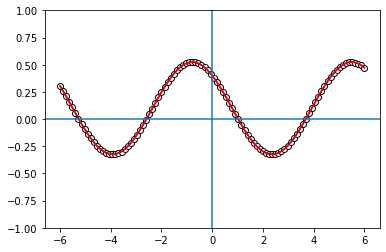

In [8]:
predictions = [quantum_model(weights_scale_1_1, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='red')
plt.ylim(-1,1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

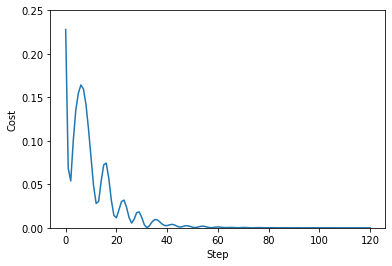

In [9]:
plt.plot(range(len(cost_1_1)), cost_1_1)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()

### Change of scale! 
The result was for scale_target = 1. and scale_train_model = 1. To obtain the second row figure from the FIG. 3 from the paper set the scale_train_model = 2 and trigger the optimizer!

In [10]:
scale_train_model = 2

# Reinitialize the (seeded) random initial weights
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True)
cost_ = [cost(weights, x, target_y)]

#  Run the optimizer for scale_target = 1 and scale_train_model = 2
(weights_scale_1_2, cost_1_2)= optimizer_func(weights)

Cost at step  15: 0.09542347605236906
Cost at step  30: 0.06831038772178118
Cost at step  45: 0.052006645759923004
Cost at step  60: 0.04787771789091735
Cost at step  75: 0.04515621242201365
Cost at step  90: 0.04914696748837678
Cost at step 105: 0.05338856198069949
Cost at step 120: 0.045558859563352316


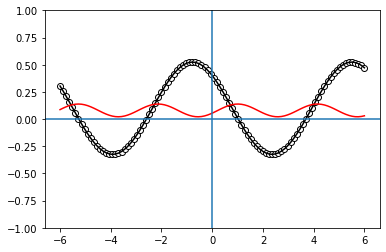

In [11]:
predictions = [quantum_model(weights_scale_1_2, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='red')
plt.ylim(-1,1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

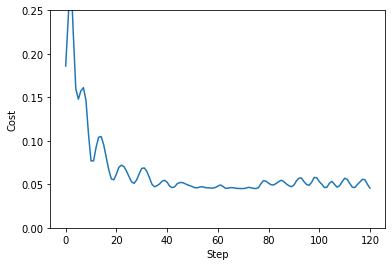

In [12]:
plt.plot(range(len(cost_1_2)), cost_1_2)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()